# CS109A Final Project L - Milestone 3
### Ilona Demler, Daniela Garcia, Kayla Manning, Saul Soto

This notebook contains the code used to produce our Milestone 3 Report.

## Import Libraries



In [13]:
# import standard libraries
import os
import pandas as pd
import sys
import numpy as np
import scipy as sp
import sklearn as sk
import itertools
import math
import missingno as msno
import re
import requests
from bs4 import BeautifulSoup

# import model tools
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor

# import viz libraries
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt

# pandas tricks for better display
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

%matplotlib inline

## Loading the Data Sample



In [5]:
# load sampled data
# download here: https://drive.google.com/file/d/1ZCZ_zToKo0_gw1TLZAnL-LP_QSijSstm/view?usp=sharing
data_sample_file_100K = "/Users/kaylamanning/Downloads/data_sample_100k.csv"
data_sam = pd.read_csv(data_sample_file_100K)
playlist_data_sample = data_sam[[c for c in data_sam.columns if 'Unnamed' not in c]]

## Adding Additional Variables from the Spotify API

In [2]:
# your code here

## Cleaning the Data [EDIT WITH SPOTIFY DATA]



In [6]:
# clean data

# initialize popular names, artists, songs
popular_names = ["country", "chill", "rap", "workout", "oldies", "christmas", "rock", "party", "throwback", 
                 "jams", "worship", "summer", "feels", "new", "disney", "lit", "throwbacks", "music", "sleep", "vibes"]

popular_artists = ["Drake", "Kanye West", "Kendrick Lamar", "Rihanna", "The Weeknd", "Eminem", "Ed Sheeran", "Future", 
                   "Justin Bieber", "J. Cole", "Beyoncé", "The Chainsmokers", "Chris Brown", "Calvin Harris", 
                   "Twenty One Pilots", "Lil Uzi Vert", "Post Malone", "Big Sean", "Maroon 5", "JAY Z"]

popular_tracks = ["HUMBLE. by Kendrick Lamar", "One Dance by Drake", "Broccoli (feat. Lil Yachty) by DRAM", 
                  "Closer by The Chainsmokers", "Congratulations by Post Malone", "Caroline by Aminé", 
                  "iSpy (feat. Lil Yachty) by KYLE", "Bad and Boujee (feat. Lil Uzi Vert) by Migos", "Location by Khalid",
                  "XO TOUR Llif3 by Lil Uzi Vert", "Bounce Back by Big Sean", "Ignition - Remix by R. Kelly", 
                  "No Role Modelz by J. Cole", "Mask Off by Future", "No Problem (feat. Lil Wayne & 2 Chainz) by Chance The Rapper",
                  "I'm the One by DJ Khaled", "Jumpman by Drake", "goosebumps by Travis Scott", "Fake Love by Drake",
                  "Despacito - Remix by Luis Fonsi"]

# extract predictor variables that don't need cleaning
playlist_data = playlist_data_sample[["num_tracks", "num_albums", "num_followers", "duration_ms", "num_artists"]].copy()

# initialize binary variables
playlist_data[["collaborative"]] = np.where(playlist_data_sample[["collaborative"]] == True, 1, 0)
playlist_data[["has_description"]] = np.where(playlist_data_sample[["description"]].isna(), 0, 1)

# create popular_name variable
popular_name = []
for playlist_name in playlist_data_sample["name"]:
    ## cast NaN values as strings
    if not isinstance(playlist_name, str):
        playlist_name = str(playlist_name)
    popular_name.append(np.where(any([name in playlist_name.lower() for name in popular_names]), 1, 0))
playlist_data[["popular_name"]] = pd.DataFrame(popular_name)

# extract track information
total_popular_tracks = []
total_popular_artists = []
playlist_tracks = playlist_data_sample["tracks"]

# iterate through each playlist
for track_data in playlist_tracks:
    # convert string to code
    track_data = eval(track_data)
    
    # initialize empty data frames to store data for each song in playlist
    pop_tracks = []
    pop_artists = []
    
    # iterate through each song in playlist
    for track_dict in track_data:
        track_name = track_dict["track_name"]
        artist_name = track_dict["artist_name"]
        
        # check if track name is popular
        if track_name + " by " + artist_name in popular_tracks:
            pop_tracks.append(1)
        else:
            pop_tracks.append(0)
        
        # check if artist name is popular
        if artist_name in popular_artists:
            pop_artists.append(1)
        else:
            pop_artists.append(0)
        
    
    # compute sum of popular songs and artists for that playlist
    total_popular_tracks.append(sum(pop_tracks))
    total_popular_artists.append(sum(pop_artists))

# add sums as new columns in data frame  
playlist_data[["total_popular_tracks"]] = pd.DataFrame(total_popular_tracks)
playlist_data[["total_popular_artists"]] = pd.DataFrame(total_popular_artists)


## Generating Train and Test Sets



In [14]:
# split data into training and test data
X_data = playlist_data[["popular_name", "has_description", "num_artists", "num_albums", "num_tracks", 
                        "duration_ms", "collaborative", "total_popular_tracks", "total_popular_artists"]].copy()
y_data = playlist_data["num_followers"].copy()

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size = 0.8, random_state = 109)

## Exploratory Data Analysis



### Filter Outcome Variable and Plot Histograms:

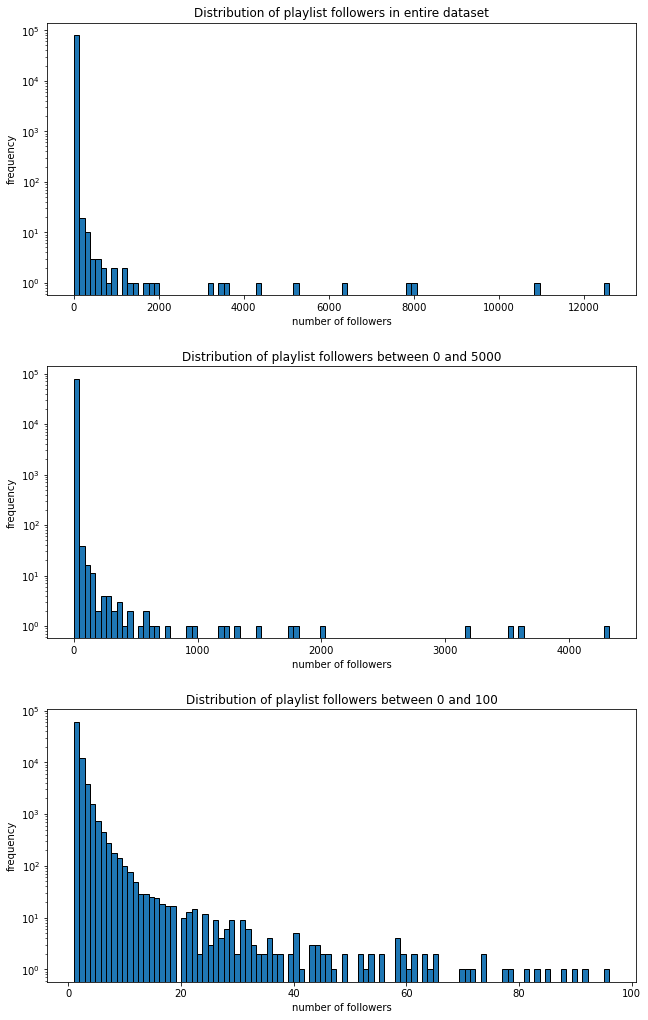

In [27]:
# filter outcome variable
y_train = y_train[y_train > 2]
y_test = y_test[y_test > 2]

# plot histograms of outcome variable
fig, ax = plt.subplots(3, 1, figsize = (10,15))
fig.tight_layout(pad = 5)

ax[0].hist(y_train, edgecolor = 'black', bins=100)
ax[0].set_yscale("log")
ax[0].set_title("Distribution of playlist followers in entire dataset")
ax[0].set_xlabel("number of followers")
ax[0].set_ylabel("frequency")

ax[1].hist(y_train[y_train<5000], edgecolor = 'black', bins=100)
ax[1].set_yscale("log")
ax[1].set_title("Distribution of playlist followers between 0 and 5000")
ax[1].set_xlabel("number of followers")
ax[1].set_ylabel("frequency")

ax[2].hist(y_train[y_train<100], edgecolor = 'black', bins=100)
ax[2].set_yscale("log")
ax[2].set_title("Distribution of playlist followers between 0 and 100")
ax[2].set_xlabel("number of followers")
ax[2].set_ylabel("frequency");


**Interpretation**

Based on these histograms, it looks like the data is very right-skewed and largely falls into either under or over 20 followers.

We considered translating `num_followers` into a binary categorical variable with a **threshold of 20**, with playlists with 20+ followers being considered "popular". However, due to the sheer number of playlists with a low number of followers, we will stick with regression.

### Collinearity

One way to check for collinearity is to plot a correlation matrix on a seaborn heatmap. The correlation matrix will show how strong a relationship is between two predictors, with correlation values close to 1 and -1 indicating a strong correlation. Predictors that are strongly correlated create a multicollinearity problem in regression, as regression usually assumes that the predictors are indepent of each other.

In [ ]:
plt.figure(figsize=(12,8))
corr = X_train.corr()
sns.heatmap(corr, annot=True, cmap='Blues').set_title('Correlation matrix between predictors');

From the correlation matrix, we can denote 6 strong relationships between variables:
* **num_tracks** and **duration_ms** (0.98)  
* **num_albums** and **num_artists** (0.96)
* **num_albums** and **num_tracks** (0.91)
* **duration_ms** and **num_albums** (0.9)
* **num_tracks** and **num_artists** (0.83)
* **duration_ms** and **num_artists** (0.81)


Another way to check collinearity between predictors is to do variance inflation factor (VIF), which checks for the variance in the regression coefficients. VIF performs a regression on one predictor against all the others, which allows it to find predictors with high variance due to collinearity. The higher the VIF value, the more likely the predictor is highly correlated with another and will affect our regression results.

In [ ]:
# Source: https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame(X_train.columns, columns=['predictor'])
vif['variance'] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]

vif

In [ ]:
# Plotting the distribution of variances 
plt.figure(figsize=(20,8))
vif_dist = sns.stripplot(data=vif, x='predictor', y='variance')
vif_dist.axhline(y=10, color='r', label='VIF collinearity cutoff')
vif_dist.set_title('Variance inflation factor (VIF) of predictors of interest')
vif_dist.text(x=2, y=12, s='values above this threshold indicate high collinearity', bbox=dict(facecolor='white', alpha=0.3))
plt.legend()
plt.show()

As you can tell from the table and the scatter plot, there are four predictors that have an inflated variance when regressed on other variables. These are the same four predictors that the correlation matrix identified as having high correlatations with other variables, and the predictors with the highest correlation between other variables in ascending order is:
* **num_artists**
* **num_albums**
* **duration_ms**
* **num_tracks**

A lot of the correlation between the predictors make sense, as the more tracks you have the longer your playlist will be. Furthermore, since the number of albums and number of artists are not highly correlated with one another, we should expect to see that there are multiple albums coming from the same artist (or vice versa) in some of the playlists. When we go on to perform our regression, we will have to consider the relationship between these four predictors as they can skew our results to the extreme.

### Response variable vs. predictors

In [ ]:
# will have to plot continuous and discrete variables differently
cat_vars = ["popular_name", "has_description", "collaborative"]
col_names = list(X_train.columns)

# creating whole training set so I can group by y_train_cat and do normalized plots with 
# percentages rather than counts
train = X_train.copy()
train['num_followers'] = y_train

# looping through and doing subplots
fig, ax = plt.subplots(3,3, figsize=(12,8))
for i in range(len(col_names)):
    
    # using this so I can assign the plots to the proper axes
    col = i%3
    row = int((i - i%3)/3)
    
    if col_names[i] in cat_vars:
        # want a boxplot for discrete variables, stratified by outcome
        sns.boxplot(x = col_names[i], y = 'num_followers', data = train, ax = ax[row,col],
                   palette = ['C0', 'orange'])
        
    else:
        # doing a histograms for continuous, filling for the category
        # getting normalized values for the counts
        ax[row,col].scatter(x = col_names[i], y = 'num_followers', data = train, s = 1)
        
    # formatting the plots with appropriate labels
    ax[row,col].set_xlabel(col_names[i])
    ax[row,col].set_title(f'{col_names[i]} by \nplaylist size')
    ax[row,col].set_yscale('log')
    
fig.tight_layout();

**Interpretation**

Based on the boxplots above, playlists that have popular names, have descriptions, and are collaborative have a greater number of followers on average.

Baseds on the scatterplots above, we see somewhat of a negative trend between the number of followers and number of artists, playlist duration, total popular tracks, and total popular artists. 

### Missing Data

In [ ]:
# your code here
display(X_train.isna().sum())
display(y_train.isna().sum())

**Interpretation**

## Model Fitting



In [ ]:
# generate a dict to store model train and test MSE's
model_mses = {} 
model_r2s = {}

### Baseline Model

Motivation:

Model Predictors: ['popular_name', 'has_description', 'num_artists', 'num_albums', 'num_tracks', 'duration_ms', 'collaborative', 'total_popular_tracks', 'total_popular_artists']

Training MSE: 6253.19
Test MSE: 10681.29


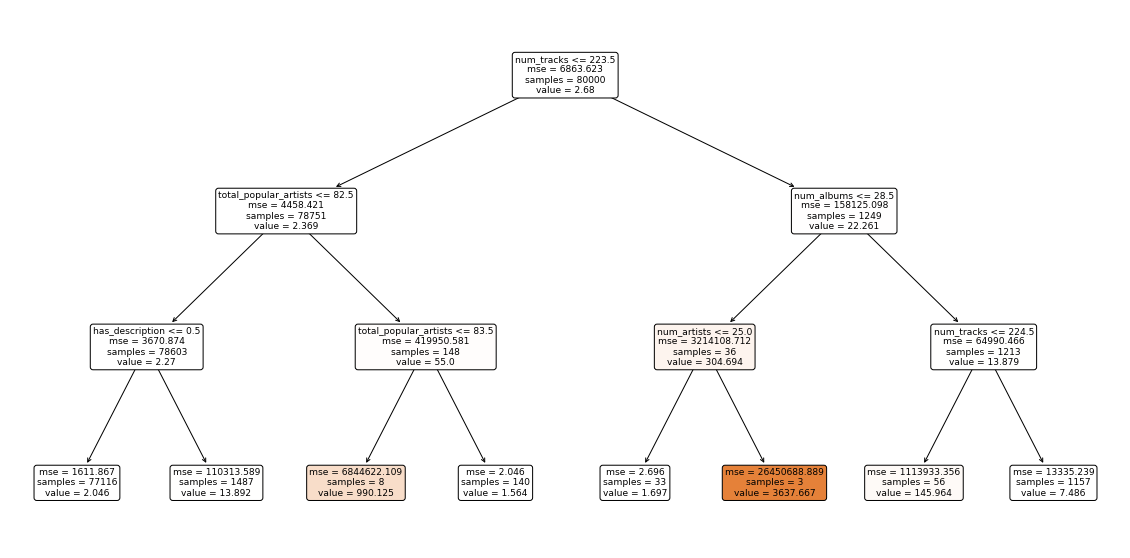

In [62]:
# Initialize a Decision Tree Regressor of depth 3 
baseline_dtree = DecisionTreeRegressor(max_depth = 3, random_state = 109)

# Fit the classifier on the train data
print(f"Model Predictors: {list(X_train.columns)}\n")
baseline_dtree.fit(X_train, y_train)
y_train_pred_dtr = baseline_dtree.predict(X_train)
y_test_pred_dtr = baseline_dtree.predict(X_test)

train_mse_dtr = mean_squared_error(y_train, y_train_pred_dtr)
test_mse_dtr = mean_squared_error(y_test, y_test_pred_dtr)
train_r2_dtr = r2_score(y_train, y_train_pred_dtr)
test_r2_dtr = r2_score(y_test, y_test_pred_dtr)
print(f"Training MSE: {train_mse_dtr:.2f} and Test MSE: {test_mse_dtr:.2f}")
print(f"Training R2: {train_r2_dtr:.2f} and Test R2: {test_r2_dtr:.2f}")

# Save MSEs to dict
model_mses["DecisionTreeRegressor"] = [train_mse_dtr, test_mse_dtr]
model_r2s["DecisionTreeRegressor"] = [train_r2_dtr, test_r2_dtr]

# Plot the Decision Tree trained above 
plt.figure(figsize = (20, 10))
tree.plot_tree(baseline_dtree, filled = True, rounded = True, feature_names = list(X_train.columns))
plt.show()


### Linear Regression

Motivation:

### Linear Regression with Cross Validation

Motivation:

### Bagging Classifier

Motivation:

### Gradient Boosting Classifier

Motivation:

## Model Assessment

In [ ]:
# compare model mses's and R2 scores
mse_results = pd.DataFrame.from_dict(model_mses, orient='index', columns=["train", "test"])
r2_results = pd.DataFrame.from_dict(model_r2s, orient='index', columns=["train", "test"])

display(mse_results)
display(r2_results)

**Interpretation**

Enter Text Here

## Conclusion

Strenghts, limitations, possible future work